In [2]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence,plot_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
# from keras.utils.vis_utils import plot_model
from tensorflow.keras.applications.vgg16 import VGG16 , preprocess_input
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap
import pickle 
import pandas as pd
from sklearn.model_selection import train_test_split


plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

In [3]:
BASE_DIR = './weather_Dataset'
WORKING_DIR = './'

In [4]:

Weather_data = pd.read_csv('./Weather_Dataset/weather_data_1.csv')
Weather_data = Weather_data.drop('Serial_ID', axis=1)
Weather_data.columns

Index(['TempHighF', 'TempAvgF', 'TempLowF', 'DewPointHighF', 'DewPointAvgF',
       'DewPointLowF', 'HumidityHighPercent', 'HumidityAvgPercent',
       'HumidityLowPercent', 'SeaLevelPressureHighInches',
       'SeaLevelPressureAvgInches', 'SeaLevelPressureLowInches',
       'VisibilityHighMiles', 'VisibilityAvgMiles', 'VisibilityLowMiles',
       'WindHighMPH', 'WindAvgMPH', 'WindGustMPH'],
      dtype='object')

In [5]:
with open(os.path.join(BASE_DIR, 'climate_data_sample_1.csv'), 'r') as f:
    next(f)
    captions_doc = f.read()

captions_doc

'1001,A child in a pink dress is climbing up a set of stairs in an entry way .\n1001,A girl going into a wooden building .\n1001,A little girl climbing into a wooden playhouse .\n1001,A little girl climbing the stairs to her playhouse .\n1001,A little girl in a pink dress going into a wooden cabin .\n1002,A black dog and a spotted dog are fighting\n1002,A black dog and a tri-colored dog playing with each other on the road .\n1002,A black dog and a white dog with brown spots are staring at each other in the street .\n1002,Two dogs of different breeds looking at each other on the road .\n1002,Two dogs on pavement moving toward each other .\n1003,A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .\n1003,A little girl is sitting in front of a large painted rainbow .\n1003,A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .\n1003,There is a girl with pigtails sitting in front of a rainbow painting .\n10

In [6]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # print("--> ", line)
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

100%|██████████| 116/116 [00:00<00:00, 115925.49it/s]


In [7]:
len(mapping)
# mapping

23

In [8]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [9]:
clean(mapping)

In [11]:
mapping['1001']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [12]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [13]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [14]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [15]:
vocab_size

303

In [16]:
max_length = max(len(caption.split()) for caption in all_captions)
max_length

21

In [17]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [18]:
image_ids

['1001',
 '1002',
 '1003',
 '1004',
 '1005',
 '1006',
 '1007',
 '1008',
 '1009',
 '1010',
 '1011',
 '1012',
 '1013',
 '1014',
 '1015',
 '1016',
 '1017',
 '1018',
 '1019',
 '1020',
 '1021',
 '1022',
 '1023']

In [20]:
with open(os.path.join(BASE_DIR, 'weather_data_1.csv'), 'r') as f:
    next(f)
    features_weathers = f.read()

features_weathers

'1001,74,60,45,67,49,43,93,75,57,29.86,29.68,29.59,10,7,2,20,4,31\n1002,56,48,39,43,36,28,93,68,43,30.41,30.13,29.87,10,10,5,16,6,25\n1003,58,45,32,31,27,23,76,52,27,30.56,30.49,30.41,10,10,10,8,3,12\n1004,61,46,31,36,28,21,89,56,22,30.56,30.45,30.3,10,10,7,12,4,20\n1005,58,50,41,44,40,36,86,71,56,30.41,30.33,30.27,10,10,7,10,2,16\n1006,57,48,39,39,36,33,79,63,47,30.47,30.4,30.34,10,9,7,12,3,17\n1007,60,53,45,41,39,37,83,65,47,30.46,30.39,30.34,10,9,7,7,1,11\n1008,62,51,40,43,39,33,92,64,36,30.33,30.17,30.04,10,10,7,10,2,14\n1009,64,50,36,49,41,28,92,76,60,30.31,30.1,29.99,10,10,4,17,5,24\n1010,44,40,35,31,26,21,75,60,45,30.44,30.33,30.26,10,10,10,13,5,21\n1011,55,46,36,31,28,23,76,54,32,30.49,30.39,30.27,10,10,10,8,1,12\n1012,69,54,39,51,42,30,83,68,52,30.25,30.11,30.01,10,10,8,13,4,22\n1013,55,44,33,39,26,19,83,55,26,30.49,30.37,30.15,10,10,9,21,8,31\n1014,58,43,28,37,22,18,75,49,22,30.48,30.35,30.14,10,10,10,14,4,21\n1015,71,57,42,55,48,38,89,68,47,30.12,29.95,29.81,10,10,8,16,7,28\

In [56]:
# create mapping of image to captions
feature_1 = {}
# process lines
for line in tqdm(features_weathers.split('\n')):
    # print("--> ", line)
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    weather_raw_info = []
    for item in caption:
        weather_raw_info.append(float(item))
        
    # print(weather_raw_info)
   
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    # create list if needed
    if image_id not in feature_1:
        feature_1[image_id] = []
    # store the caption
        
    weather_raw_info_nd_array = np.asarray(weather_raw_info)
    # print(weather_raw_info_nd_array)
    feature_1[image_id].append(np.asarray(weather_raw_info_nd_array))

type(feature_1['1001']),len(feature_1['1001'][0])

100%|██████████| 24/24 [00:00<00:00, 32367.62it/s]


(list, 18)

list

In [53]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq],num_classes=vocab_size)[0]
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

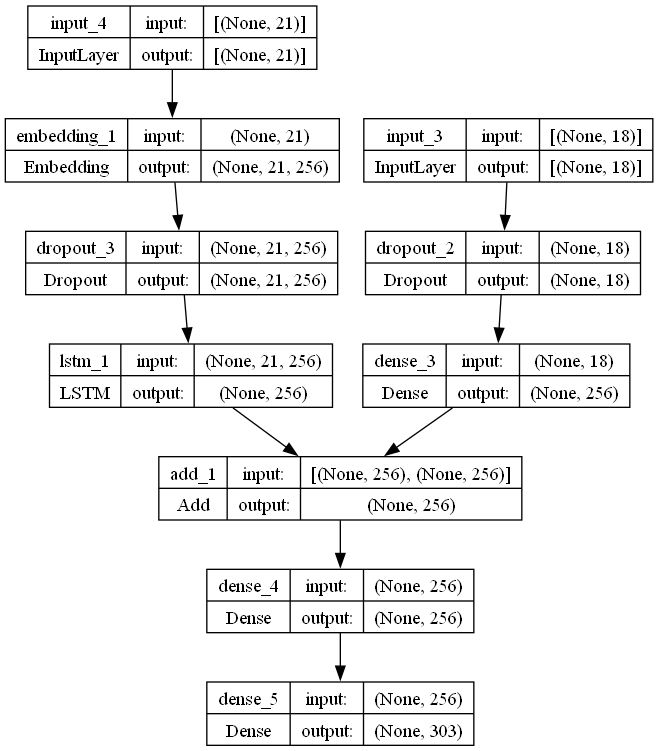

In [57]:
# encoder model
# image feature layers
inputs1 = Input(shape=(18,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

In [40]:
# train the model
epochs = 20
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, feature_1, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)


227/227 [==============================] - 351s 2s/step - loss: 2.1947


In [41]:
# save the model
model.save(WORKING_DIR+'/best_model.h5')

In [42]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [43]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
    return in_text

In [45]:
!pip install nltk

In [46]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))


100%|██████████| 810/810 [27:58<00:00,  2.07s/it] 


BLEU-1: 0.541969
BLEU-2: 0.317505


In [47]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq brown and black dog is jumping through sprinkler endseq
startseq dog playing with sprinkler endseq
startseq german shepherd runs through sprinkler endseq
startseq tan and black dog jumps through water sprinkler in the yard endseq
startseq the german shepherd dog is jumping up as it is being squirted with jet of water endseq
--------------------Predicted--------------------
startseq dog jumps through sprinkler endseq


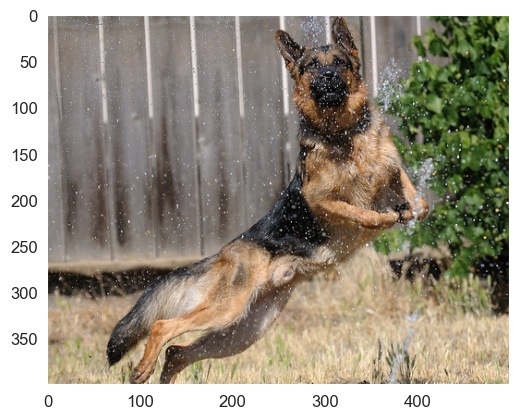

In [58]:
generate_caption("3725353555_75c346d7ec.jpg")